VQE Simulation (1) Benchmark Program - Qiskit
... execution starting at Oct 15, 2024 04:46:40 UTC
************
Executing [3] circuits with num_qubits = 4
************
Executing [3] circuits with num_qubits = 6
************
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 5, 0.0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 4 qubit group = 76, 0.533, 56.0
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.497, 0.315, 0.01 secs
Average Transpiling, Validating, Running Times for group 4 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 0.85, 0.818

************
Executing [3] circuits with num_qubits = 8
************
Average Circuit Algorithmic Depth, ξ (xi) for the 6 qubit group = 10, 0.0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 6 qubit group = 341, 0.63, 272.0
Average Creation, Elapsed, Execution Time for the 6 qubit group = 0.103, 1.121, 0.029 secs
Average Transpiling, Validati

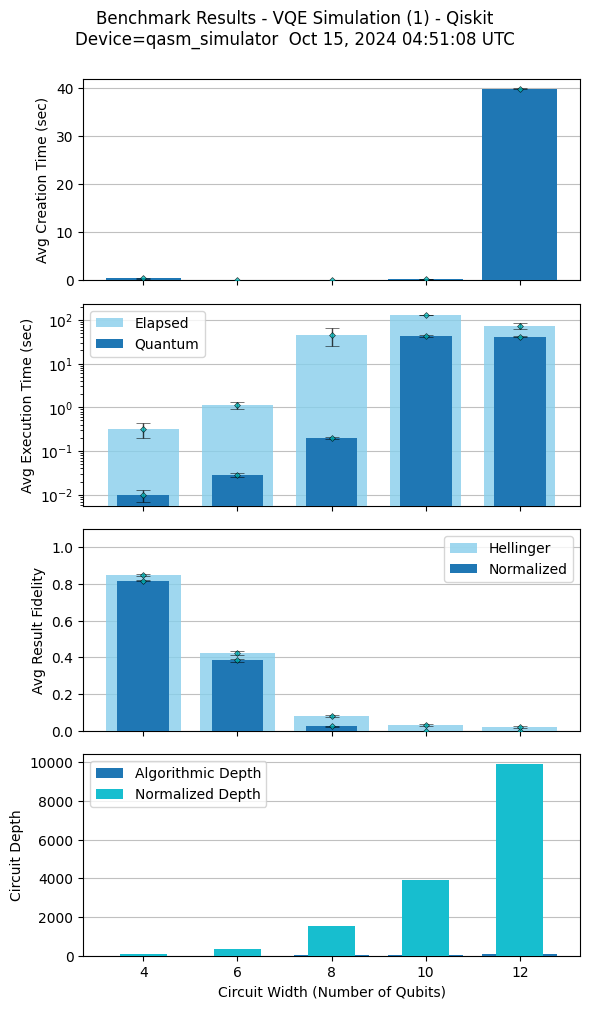

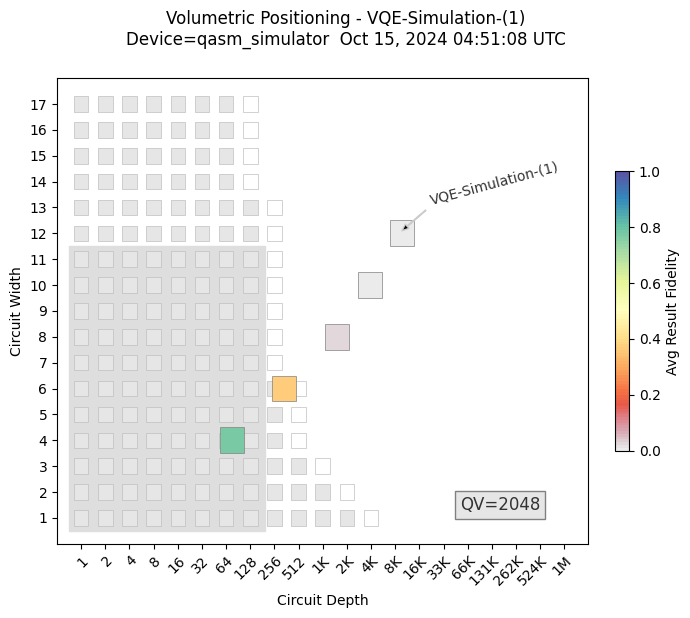

In [1]:
"""
Variational Quantum Eigensolver Benchmark Program - Qiskit
"""

import json
import os
import sys
import time

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import LieTrotter

sys.path[1:1] = ["_common", "_common/qiskit"]
sys.path[1:1] = ["../../_common", "../../_common/qiskit"]
import execute as ex
import metrics as metrics

# Benchmark Name
benchmark_name = "VQE Simulation"

verbose= False

# saved circuits for display
QC_ = None
Hf_ = None
CO_ = None

################### Circuit Definition #######################################

# Construct a Qiskit circuit for VQE Energy evaluation with UCCSD ansatz
# param: n_spin_orbs - The number of spin orbitals.
# return: return a Qiskit circuit for this VQE ansatz
def VQEEnergy(n_spin_orbs, na, nb, circuit_id=0, method=1):

    # number of alpha spin orbitals
    norb_a = int(n_spin_orbs / 2)

    # construct the Hamiltonian
    qubit_op = ReadHamiltonian(n_spin_orbs)

    # allocate qubits
    num_qubits = n_spin_orbs

    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr, name=f"vqe-ansatz({method})-{num_qubits}-{circuit_id}")

    # initialize the HF state
    Hf = HartreeFock(num_qubits, na, nb)
    qc.append(Hf, qr)

    # form the list of single and double excitations 
    excitationList = []
    for occ_a in range(na):
        for vir_a in range(na, norb_a):
            excitationList.append((occ_a, vir_a))

    for occ_b in range(norb_a, norb_a+nb):
        for vir_b in range(norb_a+nb, n_spin_orbs):
            excitationList.append((occ_b, vir_b))

    for occ_a in range(na):
        for vir_a in range(na, norb_a):
            for occ_b in range(norb_a, norb_a+nb):
                for vir_b in range(norb_a+nb, n_spin_orbs):
                    excitationList.append((occ_a, vir_a, occ_b, vir_b))

    # get cluster operators in Paulis
    pauli_list = readPauliExcitation(n_spin_orbs, circuit_id)

    # loop over the Pauli operators
    for index, PauliOp in enumerate(pauli_list):
        # get circuit for exp(-iP)
        cluster_qc = ClusterOperatorCircuit(PauliOp, excitationList[index])

        # add to ansatz
        qc.append(cluster_qc, [i for i in range(cluster_qc.num_qubits)])
        
    # method 1, only compute the last term in the Hamiltonian
    if method == 1:
        # last term in Hamiltonian
        qc_with_mea, is_diag = ExpectationCircuit(qc, qubit_op[1], num_qubits)

        # return the circuit
        return qc_with_mea

    # now we need to add the measurement parts to the circuit
    # circuit list 
    qc_list = []
    diag = []
    off_diag = []
    global normalization
    normalization = 0.0

    # add the first non-identity term
    identity_qc = qc.copy()
    identity_qc.measure_all()
    qc_list.append(identity_qc) # add to circuit list
    diag.append(qubit_op[1])
    normalization += abs(qubit_op[1].coeffs[0]) # add to normalization factor
    diag_coeff = abs(qubit_op[1].coeffs[0]) # add to coefficients of diagonal terms

    # loop over rest of terms 
    for index, p in enumerate(qubit_op[2:]):
        
        # get the circuit with expectation measurements
        qc_with_mea, is_diag = ExpectationCircuit(qc, p, num_qubits)

        # accumulate normalization 
        normalization += abs(p.coeffs[0])

        # add to circuit list if non-diagonal
        if not is_diag:
            qc_list.append(qc_with_mea)
        else:
            diag_coeff += abs(p.coeffs[0])

        # diagonal term
        if is_diag:
            diag.append(p)
        # off-diagonal term
        else:
            off_diag.append(p)

    # modify the name of diagonal circuit
    qc_list[0].name = qubit_op[1].primitive.to_list()[0][0] + " " + str(np.real(diag_coeff))
    normalization /= len(qc_list)
    return qc_list

# Function that constructs the circuit for a given cluster operator
def ClusterOperatorCircuit(pauli_op, excitationIndex):
    
    num_qubits = pauli_op.num_qubits
    
    # compute exp(-iP) with 1st order Trotter step
    qc_op = PauliEvolutionGate(pauli_op, synthesis=LieTrotter())
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_op, range(num_qubits))
    qc.name = f'Cluster Op {excitationIndex}'
    
    global CO_
    if CO_ == None or qc.num_qubits <= 4:
        if qc.num_qubits < 7: CO_ = qc

    # return this circuit
    return qc


# Function that adds expectation measurements to the raw circuits
def ExpectationCircuit(qc, pauli, nqubit, method=2):

    # copy the unrotated circuit
    raw_qc = qc.copy()

    # whether this term is diagonal
    is_diag = True

    # primitive Pauli string
    PauliString = pauli.to_list()[0][0]

    # coefficient
    coeff = pauli.coeffs[0]

    # basis rotation
    for i, p in enumerate(PauliString):
    
        target_qubit = nqubit - i - 1 
        if (p == "X"):
            is_diag = False
            raw_qc.h(target_qubit)
        elif (p == "Y"):
            raw_qc.sdg(target_qubit)
            raw_qc.h(target_qubit)
            is_diag = False

    # perform measurements
    raw_qc.measure_all()

    # name of this circuit
    raw_qc.name = PauliString + " " + str(np.real(coeff))

    # save circuit
    global QC_
    if QC_ == None or nqubit <= 4:
        if nqubit < 7: QC_ = raw_qc

    return raw_qc, is_diag

# Function that implements the Hartree-Fock state 
def HartreeFock(norb, na, nb):

    # initialize the quantum circuit
    qc = QuantumCircuit(norb, name="Hf")
    
    # alpha electrons
    for ia in range(na):
        qc.x(ia)

    # beta electrons
    for ib in range(nb):
        qc.x(ib+int(norb/2))

    # Save smaller circuit
    global Hf_
    if Hf_ == None or norb <= 4:
        if norb < 7: Hf_ = qc

    # return the circuit
    return qc

################ Helper Functions

# Function that converts a list of single and double excitation operators to Pauli operators
def readPauliExcitation(norb, circuit_id=0):

    # load pre-computed data
    filename = os.path.join(f'./ansatzes/{norb}_qubit_{circuit_id}.txt')
    with open(filename) as f:
        data = f.read()
    ansatz_dict = json.loads(data)

    # initialize Pauli list
    pauli_list = []

    # current coefficients 
    cur_coeff = 1e5

    # current Pauli list 
    cur_list = []

    # loop over excitations
    for ext in ansatz_dict:

        if cur_coeff > 1e4:
            cur_coeff = ansatz_dict[ext]
            cur_list = [(ext, ansatz_dict[ext])]
        elif abs(abs(ansatz_dict[ext]) - abs(cur_coeff)) > 1e-4:
            pauli_list.append(SparsePauliOp.from_list(cur_list))
            cur_coeff = ansatz_dict[ext]
            cur_list = [(ext, ansatz_dict[ext])]
        else:
            cur_list.append((ext, ansatz_dict[ext]))
        
    # add the last term
    pauli_list.append(SparsePauliOp.from_list(cur_list))

    # return Pauli list
    return pauli_list

# Get the Hamiltonian by reading in pre-computed file
def ReadHamiltonian(nqubit):

    # load pre-computed data
    filename = os.path.join(f'./Hamiltonians/{nqubit}_qubit.txt')
    with open(filename) as f:
        data = f.read()
    ham_dict = json.loads(data)

    # pauli list 
    pauli_list = []
    for p in ham_dict:
        pauli_list.append( (p, ham_dict[p]) )

    # build Hamiltonian
    ham = SparsePauliOp.from_list(pauli_list)

    # return Hamiltonian
    return ham

################ Result Data Analysis

## Analyze and print measured results
## Compute the quality of the result based on measured probability distribution for each state
def analyze_and_print_result(qc, result, num_qubits, references, num_shots):

    # total circuit name (pauli string + coefficient)
    total_name = qc.name

    # pauli string
    pauli_string = total_name.split()[0]

    # get results counts
    counts = result.get_counts(qc)

    # get the correct measurement
    if (len(total_name.split()) == 2):
        correct_dist = references[pauli_string]
    else:
        circuit_id = int(total_name.split()[2])
        correct_dist = references[f"Qubits - {num_qubits} - {circuit_id}"]

    # compute fidelity
    fidelity = metrics.polarization_fidelity(counts, correct_dist)

    # modify fidelity based on the coefficient
    if (len(total_name.split()) == 2):
        fidelity *= ( abs(float(total_name.split()[1])) / normalization )

    return fidelity

################ Benchmark Loop

# Max qubits must be 12 since the referenced files only go to 12 qubits
MAX_QUBITS = 12
    
# Execute program with default parameters
def run(min_qubits=4, max_qubits=12, skip_qubits=1,
        max_circuits=3, num_shots=4092, method=1,
        backend_id="qasm_simulator", provider_backend=None,
        hub="ibm-q", group="open", project="main", exec_options=None,
        context=None):

    print(f"{benchmark_name} ({method}) Benchmark Program - Qiskit") 

    max_qubits = max(max_qubits, min_qubits)        # max must be >= min

    # validate parameters (smallest circuit is 4 qubits and largest is 10 qubitts)
    max_qubits = min(max_qubits, MAX_QUBITS)
    min_qubits = min(max(4, min_qubits), max_qubits)
    if min_qubits % 2 == 1: min_qubits += 1  # min_qubits must be even
    skip_qubits = max(1, skip_qubits)
    
    if method == 2: max_circuits = 1

    if max_qubits < 4:
        print(f"Max number of qubits {max_qubits} is too low to run method {method} of VQE algorithm")
        return

    # create context identifier
    if context is None: context = f"{benchmark_name} ({method}) Benchmark"
    
    ##########
    
    # Initialize the metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, type, num_shots):

        # load pre-computed data
        if len(qc.name.split()) == 2:
            filename = os.path.join(f'../_common/precalculated_data_{num_qubits}_qubit.json')
            with open(filename) as f:
                references = json.load(f)
        else:
            filename = os.path.join(f'../_common/precalculated_data_{num_qubits}_qubit_method2.json')
            with open(filename) as f:
                references = json.load(f)

        fidelity = analyze_and_print_result(qc, result, num_qubits, references, num_shots)

        if len(qc.name.split()) == 2:
            metrics.store_metric(num_qubits, qc.name.split()[0], 'fidelity', fidelity)
        else:
            metrics.store_metric(num_qubits, qc.name.split()[2], 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options,
            context=context)

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for input_size in range(min_qubits, max_qubits + 1, 2):

        # reset random seed
        np.random.seed(0)

        # determine the number of circuits to execute for this group
        num_circuits = min(3, max_circuits)

        num_qubits = input_size

        # decides number of electrons
        na = int(num_qubits/4)
        nb = int(num_qubits/4)

        # random seed
        np.random.seed(0)

        # create the circuit for given qubit size and simulation parameters, store time metric
        ts = time.time()

        # circuit list 
        qc_list = []

        # Method 1 (default)
        if method == 1:
            # loop over circuits
            for circuit_id in range(num_circuits):

                # construct circuit 
                qc_single = VQEEnergy(num_qubits, na, nb, circuit_id, method)               
                qc_single.name = qc_single.name + " " + str(circuit_id) 

                # add to list 
                qc_list.append(qc_single)
        # method 2
        elif method == 2:

            # construct all circuits
            qc_list = VQEEnergy(num_qubits, na, nb, 0, method)

        print(f"************\nExecuting [{len(qc_list)}] circuits with num_qubits = {num_qubits}")

        for qc in qc_list:

            # get circuit id
            if method == 1:
                circuit_id = qc.name.split()[2]
            else:
                circuit_id = qc.name.split()[0]

            # record creation time
            metrics.store_metric(input_size, circuit_id, 'create_time', time.time() - ts)

            # collapse the sub-circuits used in this benchmark (for qiskit)
            qc2 = qc.decompose()

            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc2, input_size, circuit_id, num_shots)

        # Wait for some active circuits to complete; report metrics when group complete
        ex.throttle_execution(metrics.finalize_group)

    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)

    ##########
    
    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nHartree Fock Generator 'Hf' ="); print(Hf_ if Hf_ != None else " ... too large!")
    print("\nCluster Operator Example 'Cluster Op' ="); print(CO_ if CO_ != None else " ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} ({method}) - Qiskit")

# if main, execute methods     
if __name__ == "__main__": run()
